# Creating a clean plate

### Wczytanie i rozpakowanie pliku zip

In [ ]:
!wget -O cathedral.zip http://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip && unzip -o cathedral.zip

--2022-04-26 14:35:01--  http://grail.cs.washington.edu/projects/photomontage/data/cathedral.zip
Resolving grail.cs.washington.edu (grail.cs.washington.edu)... 128.208.5.93, 2607:4000:200:14::5d
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1342082 (1.3M) [application/zip]
Saving to: ‘cathedral.zip’

cathedral.zip       100%[===================>]   1.28M   114 B/s    in 6.4s    

2022-04-26 14:35:08 (205 KB/s) - ‘cathedral.zip’ saved [1342082/1342082]

Archive:  cathedral.zip
  inflating: cathedral/d001.jpg      
  inflating: cathedral/d002.jpg      
  inflating: cathedral/d003.jpg      
  inflating: cathedral/d004.jpg      
  inflating: cathedral/d005.jpg      
  inflating: cathedral/result.png    


### Import niezbędnych bibliotek

In [ ]:
import os 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
from scipy import stats

### Helpers

In [ ]:
def l_threshold(i, threshold):
    ret = i.copy()
    ret[ret < threshold] = threshold
    return ret


def u_threshold(i, threshold):
    ret = i.copy()
    ret[ret > threshold] = threshold
    return ret

def cut_threshold(i, threshold):
    ret = i.copy()
    ret[ret < threshold] = 0
    return ret


def Q(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  return np.minimum(img_bin, x)

def G(img_bin, struct):
  x = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  return np.maximum(img_bin, x)

def A(f, struct):
  x = cv2.morphologyEx(f, cv2.MORPH_OPEN, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)
  x1 = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)

  x = cv2.morphologyEx(f, cv2.MORPH_CLOSE, struct)
  x = cv2.morphologyEx(x, cv2.MORPH_OPEN, struct)
  x2 = cv2.morphologyEx(x, cv2.MORPH_CLOSE, struct)

  return np.maximum(x1, np.minimum(f, x2))

def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

W rozwiązaniu wykorzystane zostały dwie metody polegające na obliczaniu różnicy między pikselami w obrazach wykorzystując wykrywanie krawędzi w skali monochromatycznej.

In [ ]:
paths = os.listdir("cathedral/")
result = cv2.imread("cathedral/result.png")
paths.remove("result.png")
images = []

for i, img in enumerate(paths):
  img = cv2.imread("cathedral/"+img)
  images.append(img)

In [ ]:
images_gs = []
for img in images:
    images_gs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

images_shape = []
for img in images_gs:
    lap = cv2.Laplacian(img, cv2.CV_64F)
    lap = lap.clip(0, 255).astype('uint8')
    images_shape.append(lap)

In [ ]:
def dist(img):
    x = img
    x = u_threshold(x, 100)
    x = x / np.max(x) * 255
    x = cv2.blur(x, (2,2))
    x = cv2.dilate(x, np.ones((4, 4), np.uint8))

    return x

# Funkcja wybierająca piksele z obrazków na podstawie ich masek
def choose_by_mask(images, diff_base):
  res = np.zeros(shape = images[0].shape)
  for i, ei in enumerate(images[0]):
    for j, ej in enumerate(images[0][i]):

      bestest_img = 0
      bestest_value = 255

      for img_id in range(0, len(diff_base)):
        for comp_id in range(0, len(diff_base)):
          if img_id == comp_id:
            continue
          if diff_base[img_id][comp_id][i][j] < bestest_value:
            bestest_value = diff_base[img_id][comp_id][i][j]
            bestest_img = img_id
      
      res[i][j] = images[bestest_img][i][j]
  return res

##### Znajdowanie różnic pomiędzy obrazami za pomocą wykrywania krawędzi

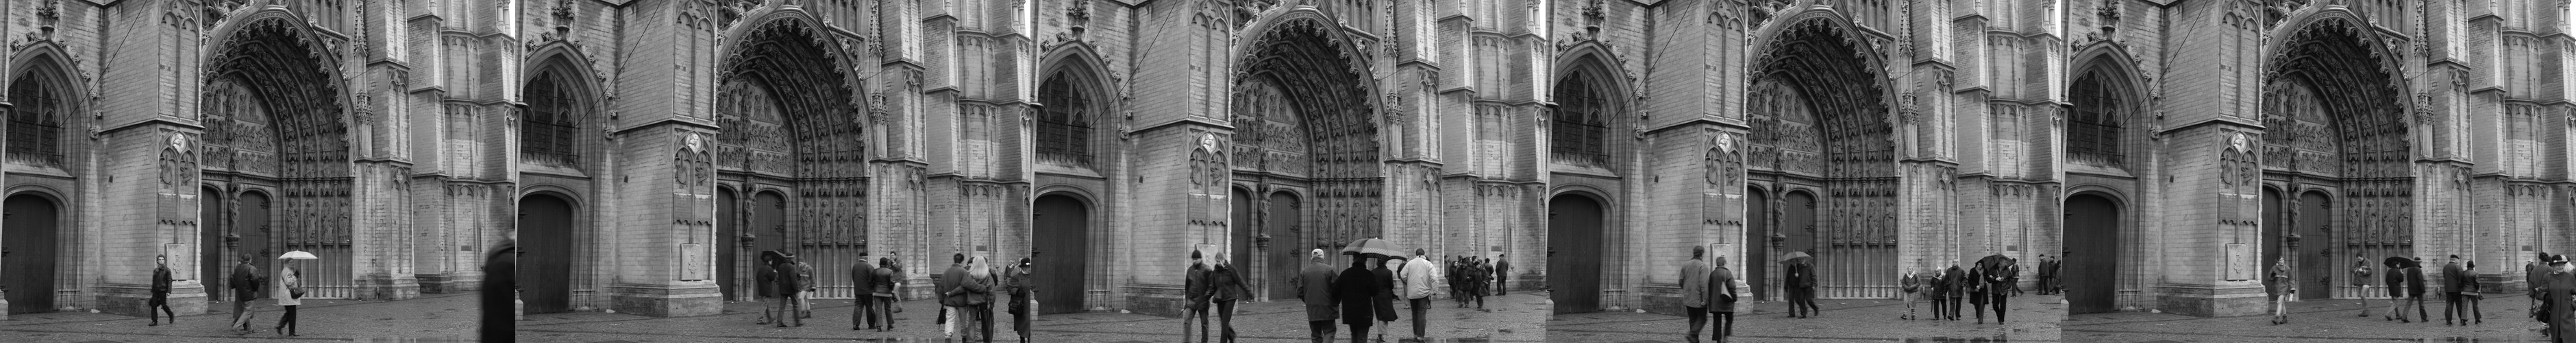

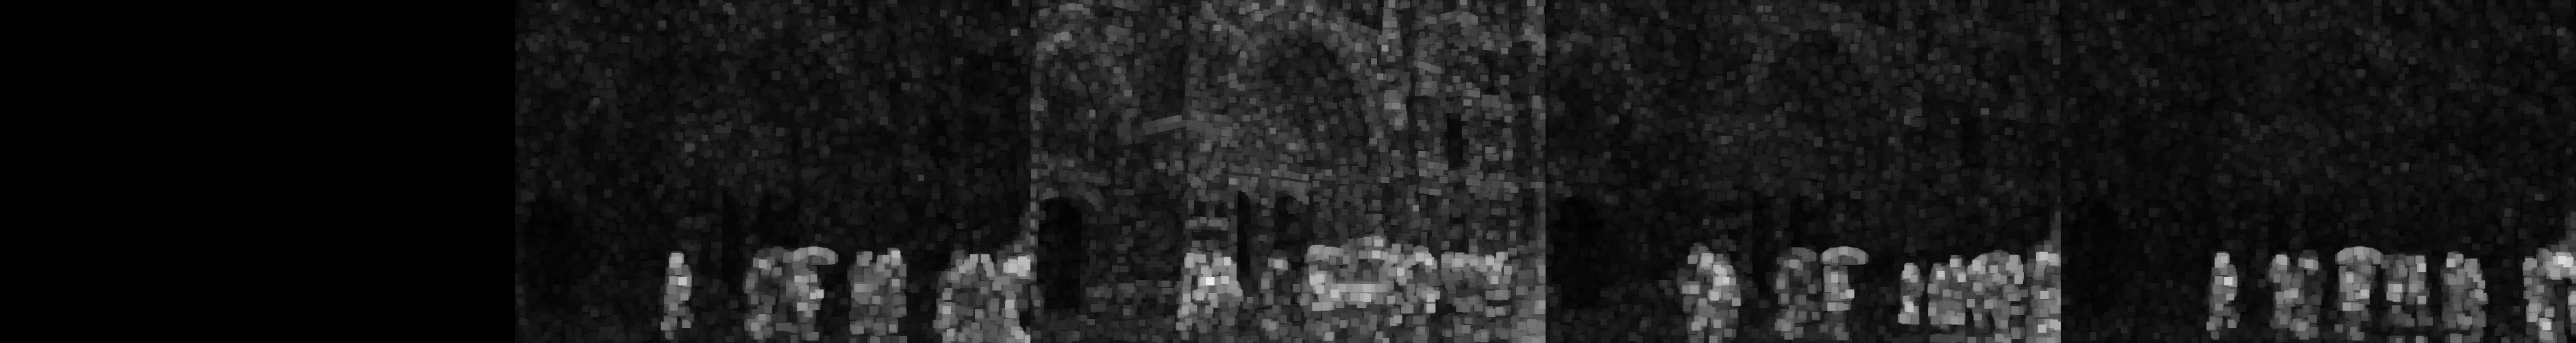

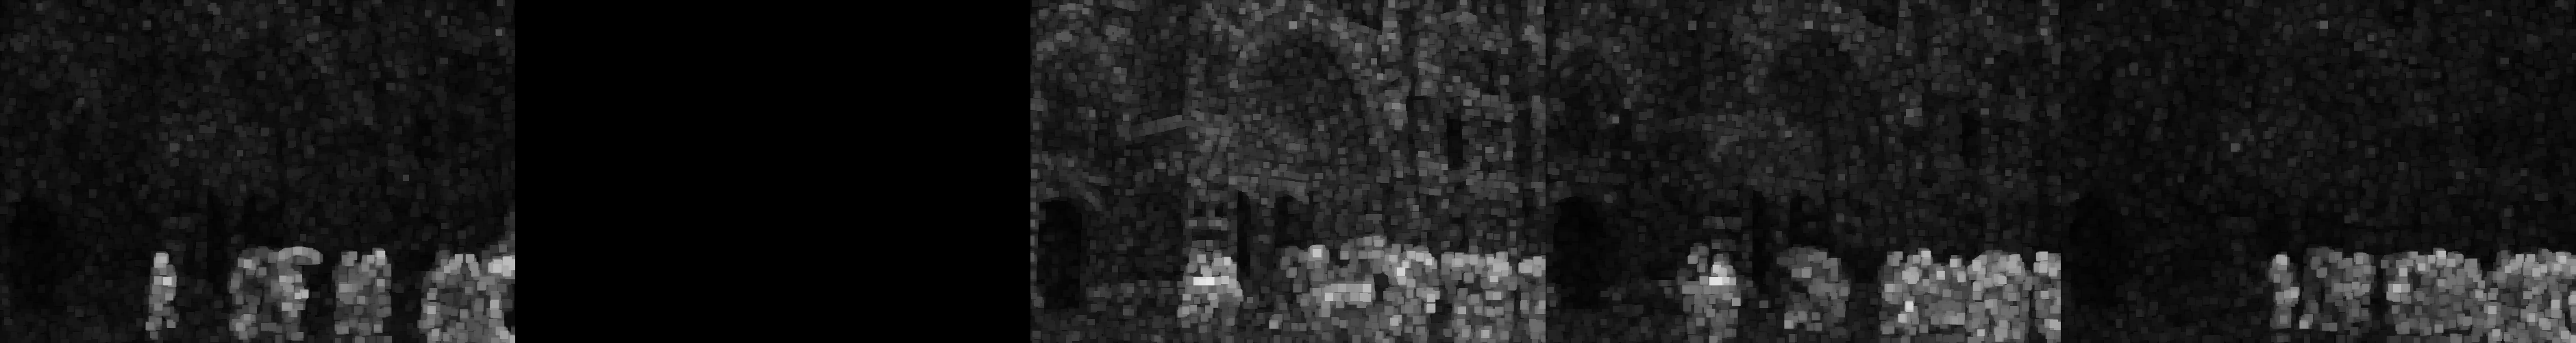

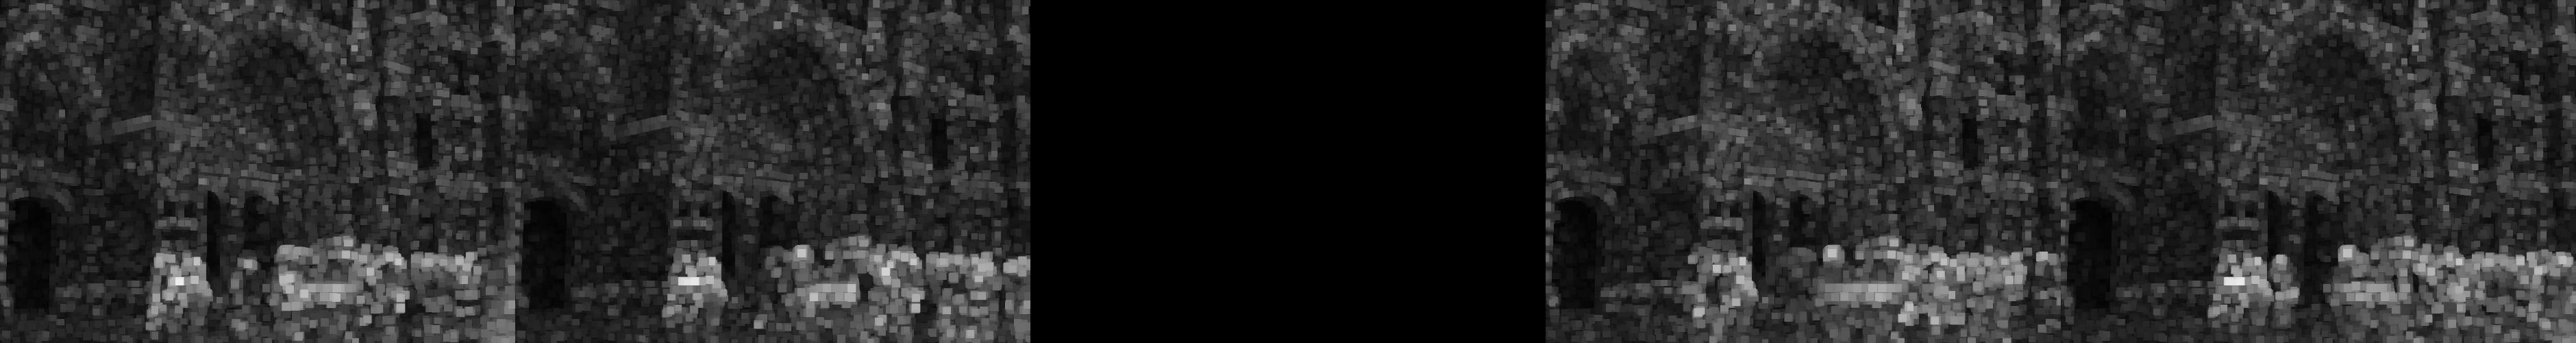

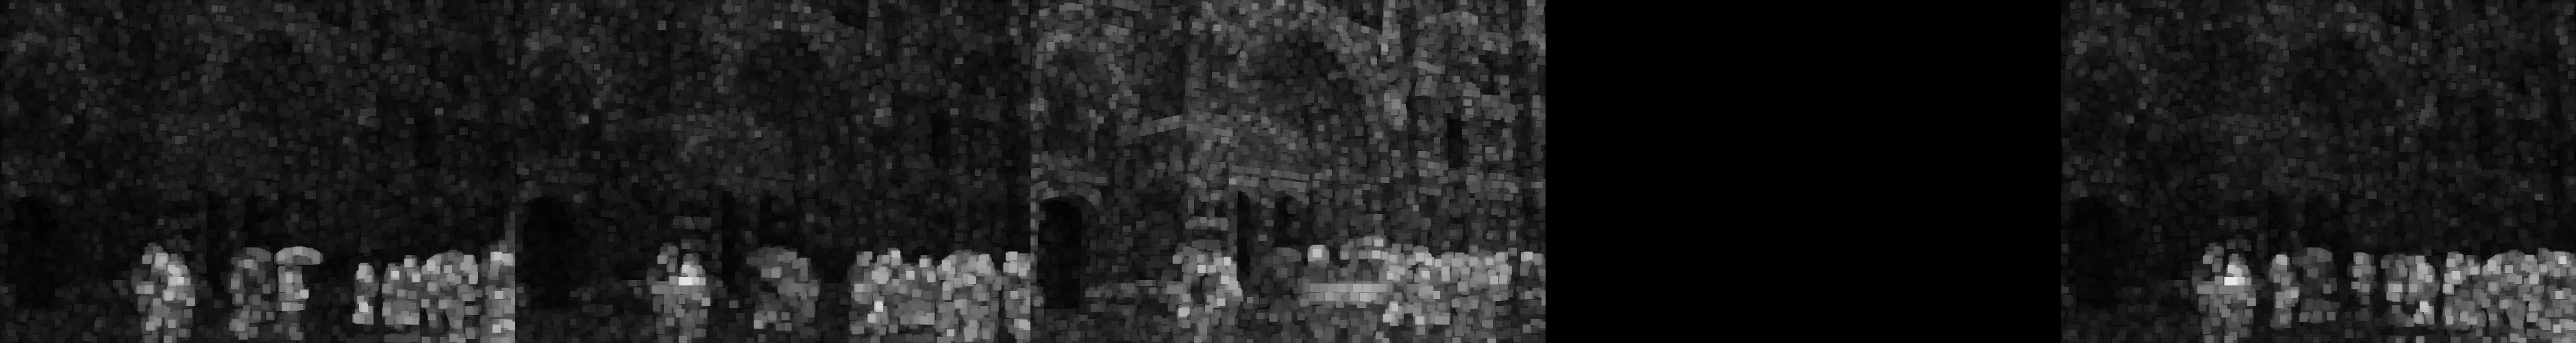

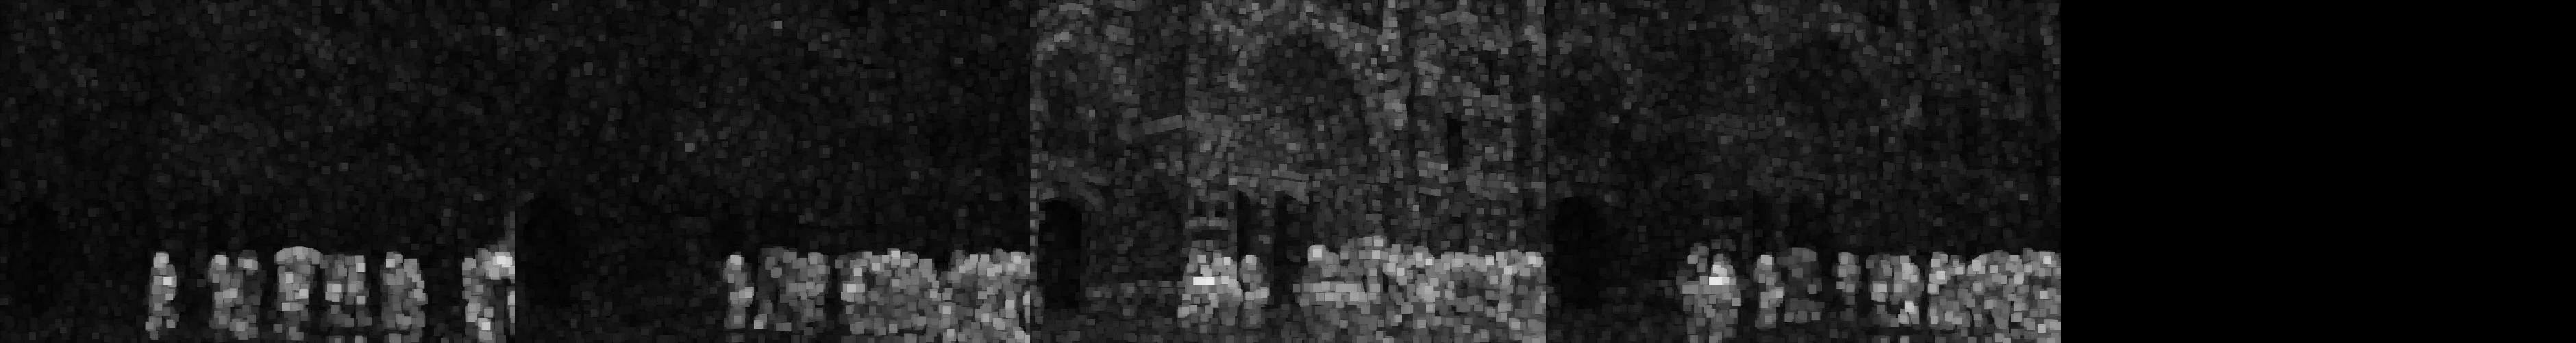

In [ ]:
diff = np.zeros((len(images_shape), len(images_shape)) + images_shape[0].shape)
images_shape_dist = []
for img_e in  images_shape:
    images_shape_dist.append(dist(img_e))

fill_ker=np.array([[0.25, 0.5, 0.25],
                    [0.5, 1, 0.5],
                    [0.25, 0.5, 0.25]])

for i in range(0, len(images_shape_dist)):
    for j in range(0, len(images_shape_dist)):
        diff[i][j] = cv2.dilate(abs(images_shape_dist[i] - images_shape_dist[j]), fill_ker, iterations=4)


imshow(np.concatenate(images_gs, 1))
imshow(np.concatenate(diff[0], 1))
imshow(np.concatenate(diff[1], 1))
imshow(np.concatenate(diff[2], 1))
imshow(np.concatenate(diff[3], 1))
imshow(np.concatenate(diff[4], 1))

##### Znajdowanie różnic na podstawie różnicy między obrazami w skali monochromatycznej

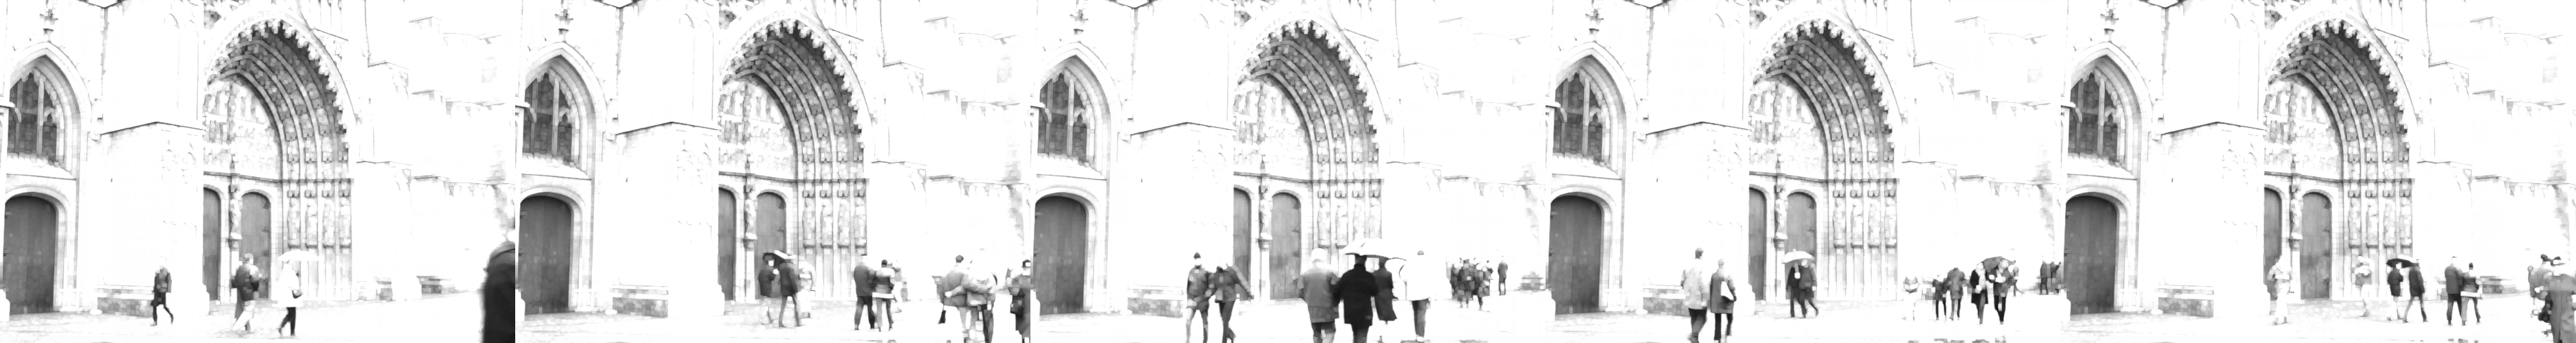

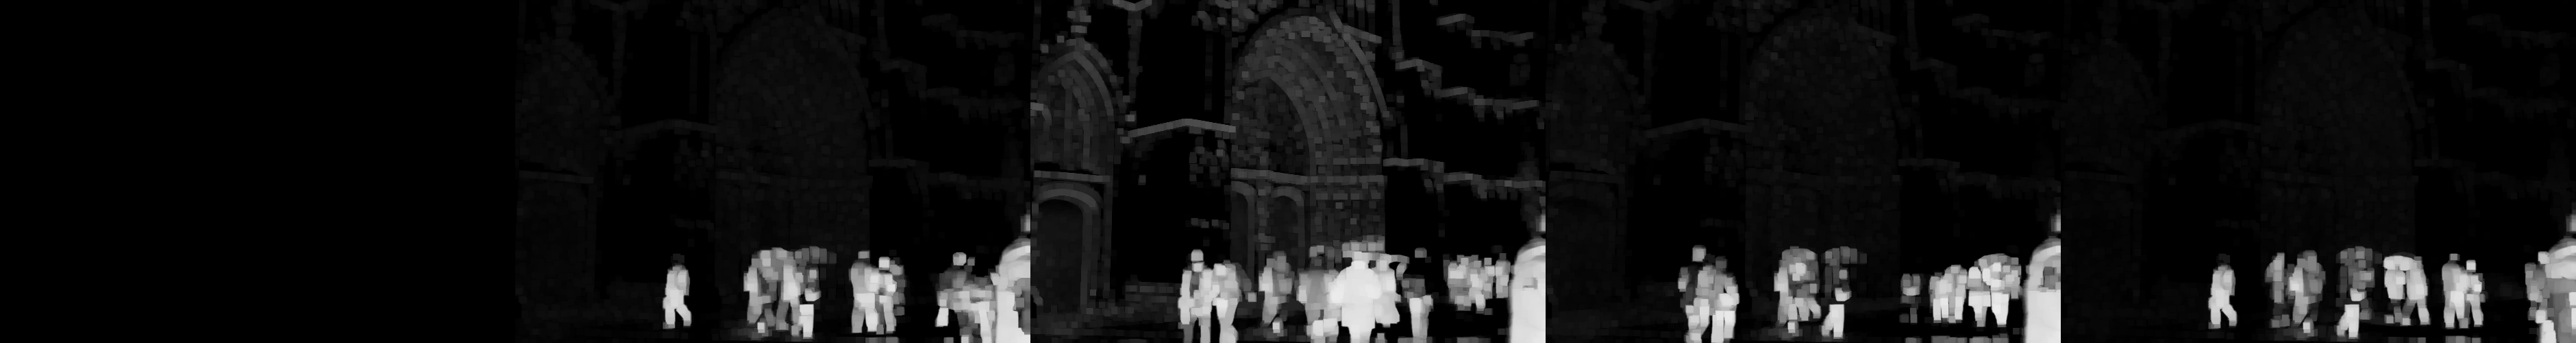

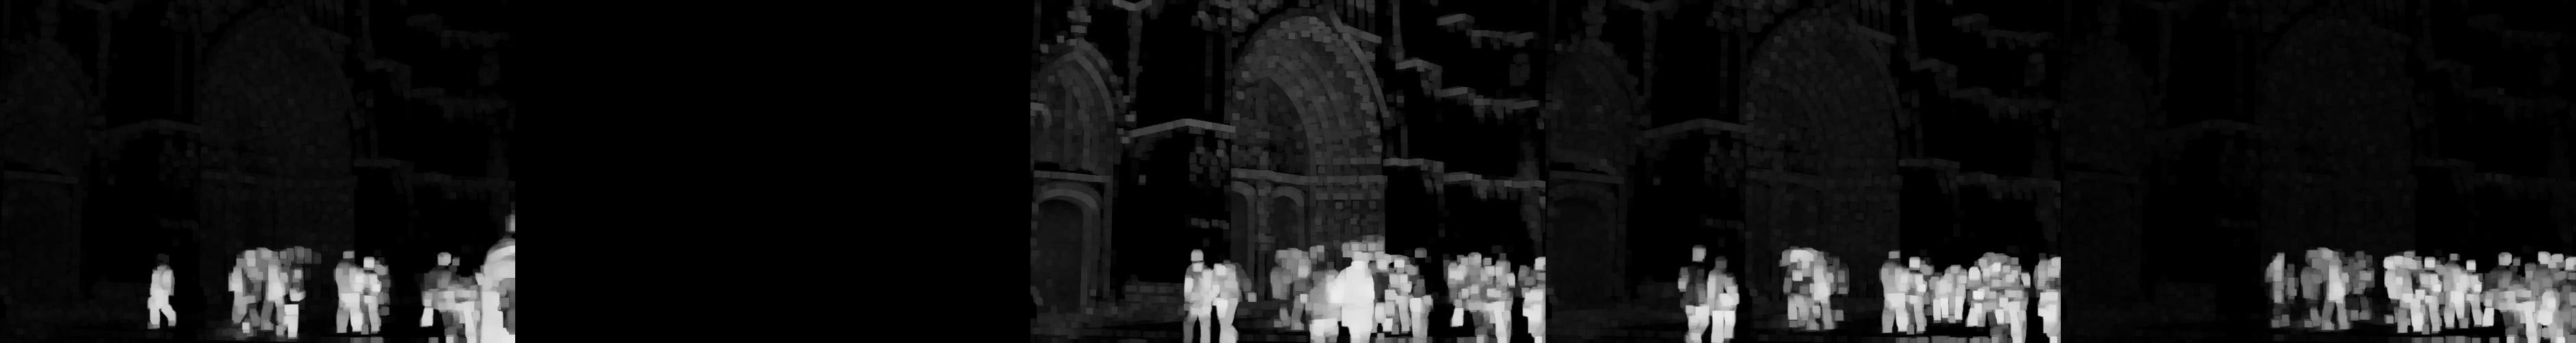

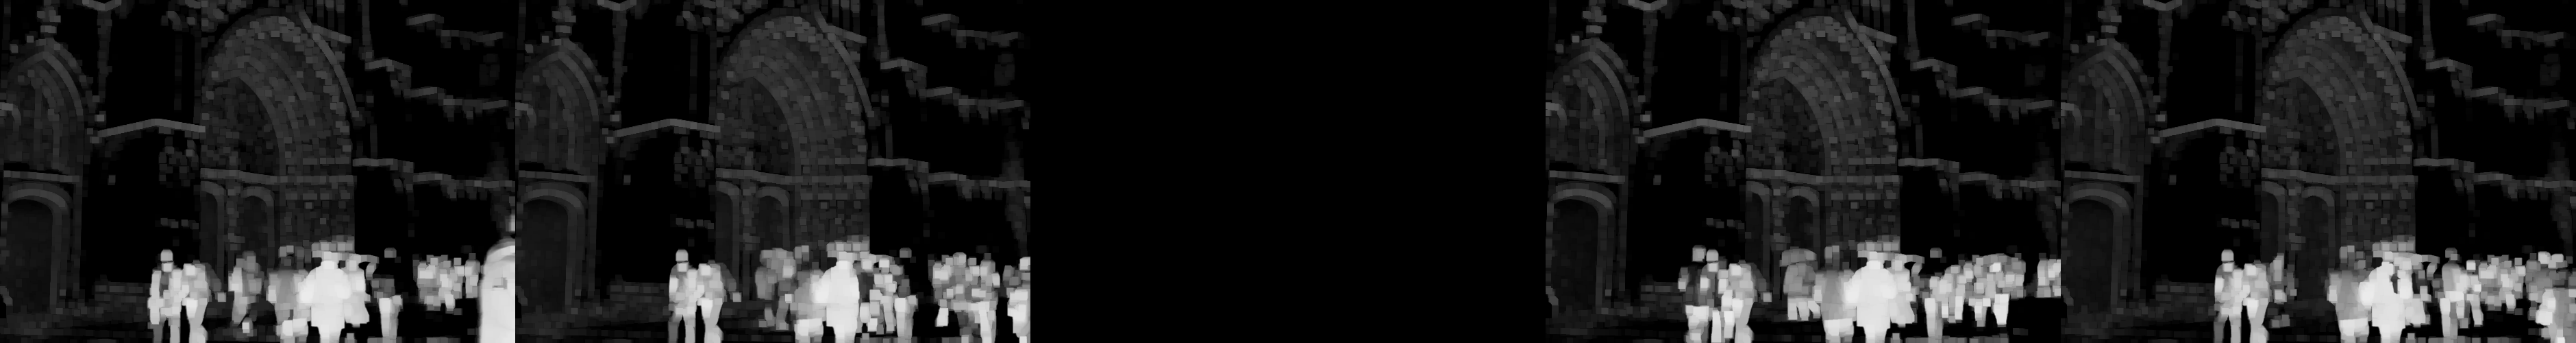

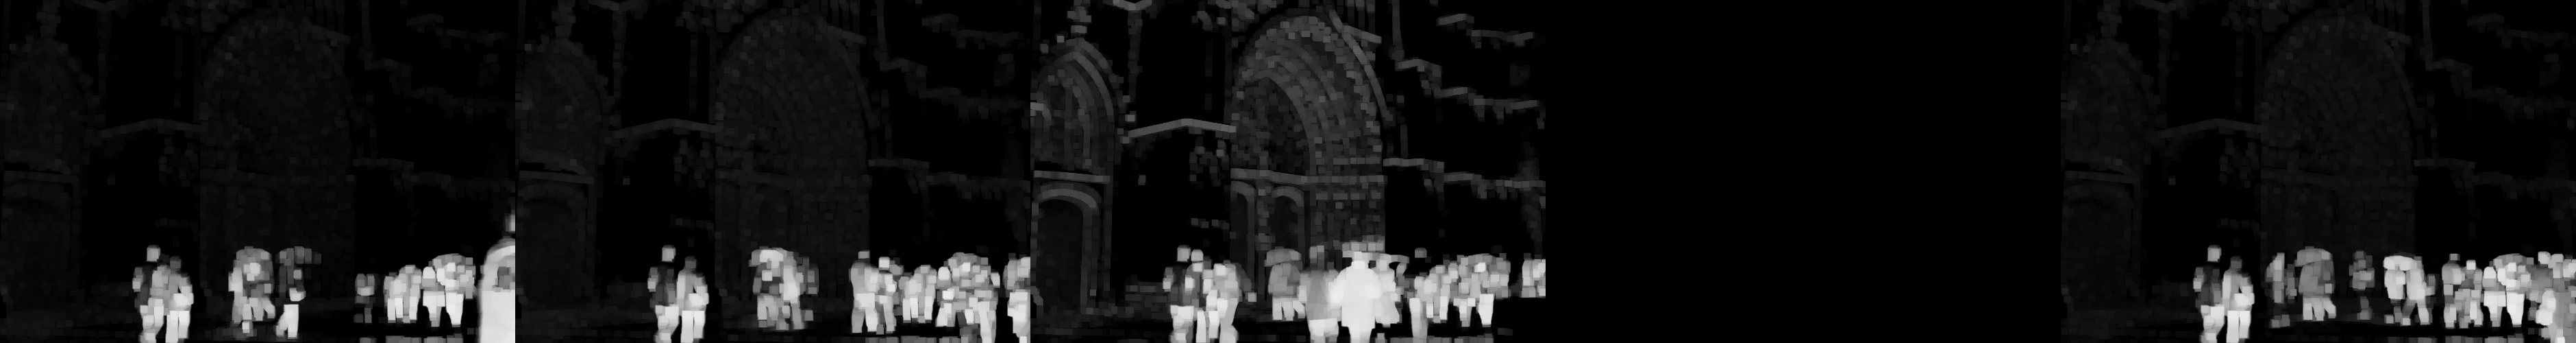

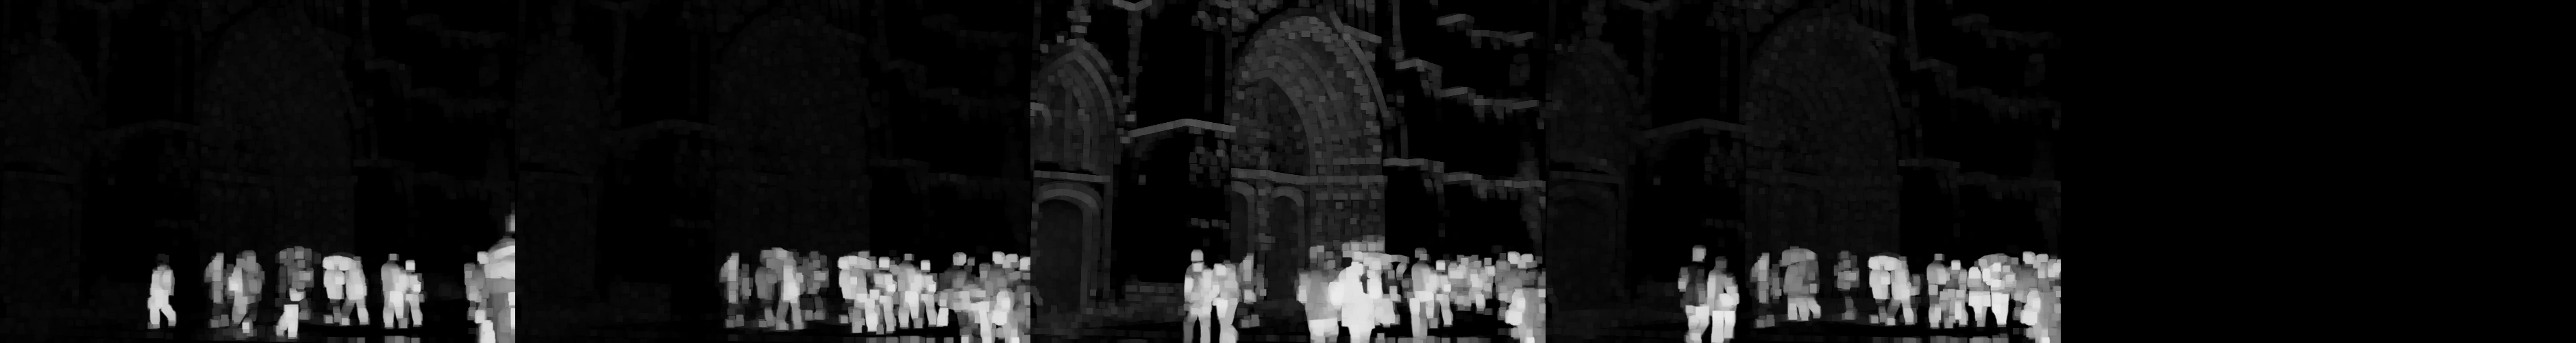

In [ ]:
img_diff = np.zeros((len(images_shape),len(images_shape)) + images_shape[0].shape)
img_dist = []

for e in images_gs:
  img_dist.append(dist(e))
  
fill_ker=np.array([[0.34, 0.34, 0.34],
                    [0.34, 1, 0.34],
                    [0.34, 0.34, 0.34]])

for i in range(0, len(images_shape_dist)):
  for j in range(0, len(images_shape_dist)):
    img_diff[i][j] = cv2.dilate(abs(img_dist[i] - img_dist[j]), fill_ker, iterations=4)



imshow(np.concatenate(img_dist, 1))
imshow(np.concatenate(img_diff[0], 1))
imshow(np.concatenate(img_diff[1], 1))
imshow(np.concatenate(img_diff[2], 1))
imshow(np.concatenate(img_diff[3], 1))
imshow(np.concatenate(img_diff[4], 1))

Powyższe różnice między obrazami w głównej mierze pokazują sylwetki ludzi, którzy przechodzili wzdłuż katedry.

##### Wyznaczenie obrazu wynikowego

Porównanie wyników dla różnicy między obrazami z wykrytymi krawędziami i różnicy między obrazami w skali monochromatycznej z wynikiem bazowym.

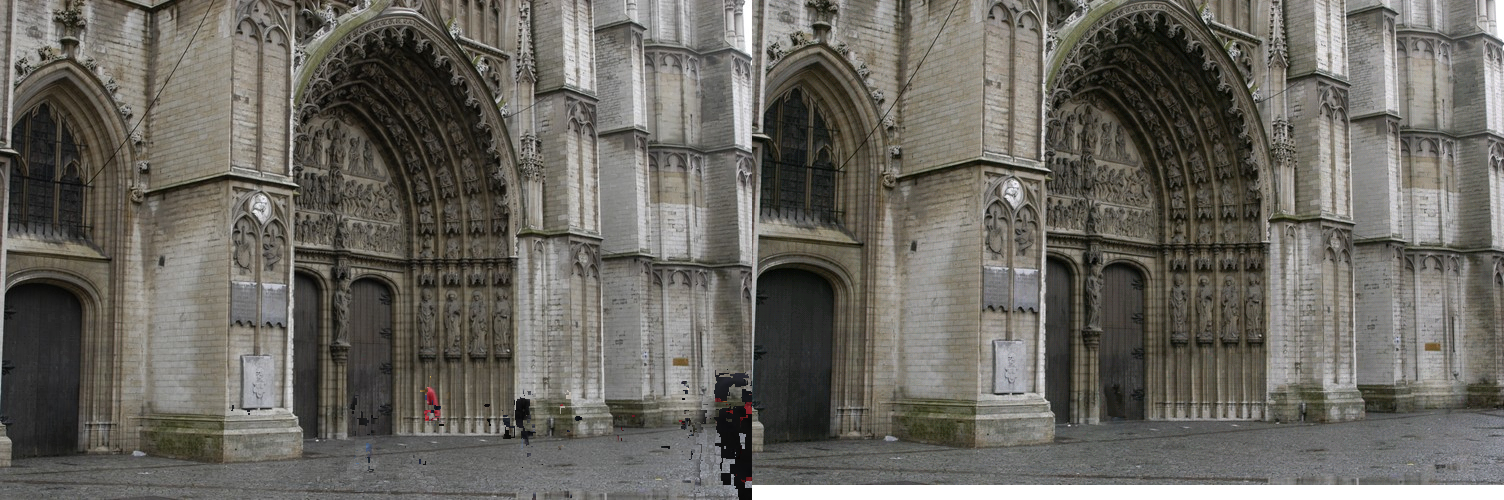

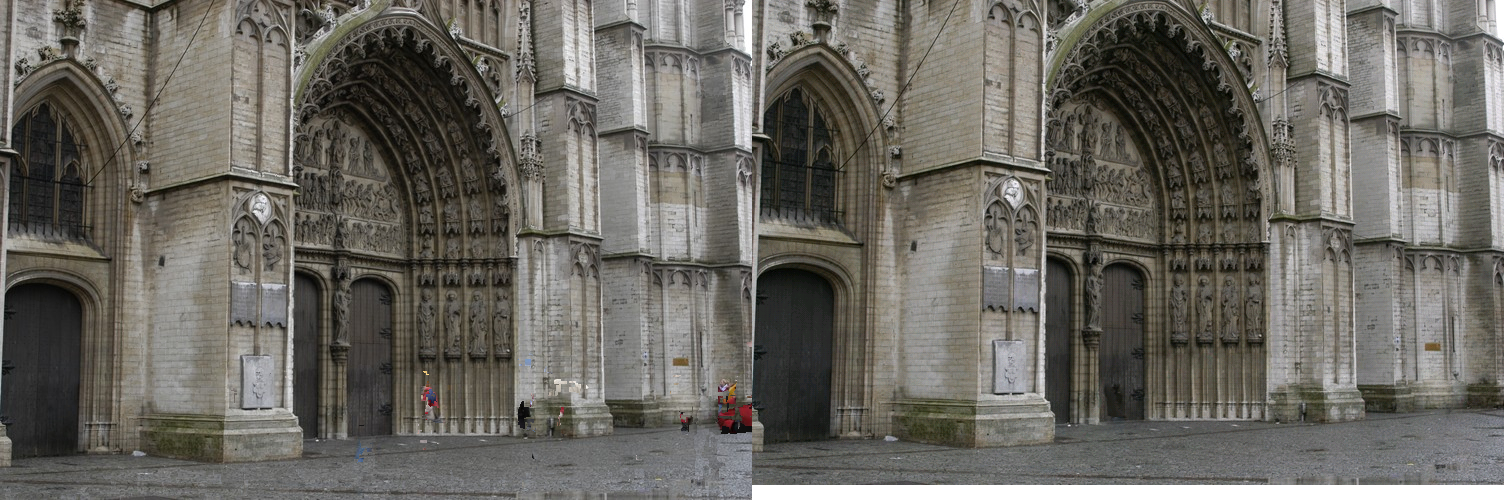

In [ ]:
imshow(np.concatenate([choose_by_mask(images, diff), result], 1))
imshow(np.concatenate([choose_by_mask(images, img_diff), result], 1))


Wyznaczenie maski będącej sumą różnic po krawędziach i po obrazach oraz porównanie jej wyniku z obrazem bazowym.

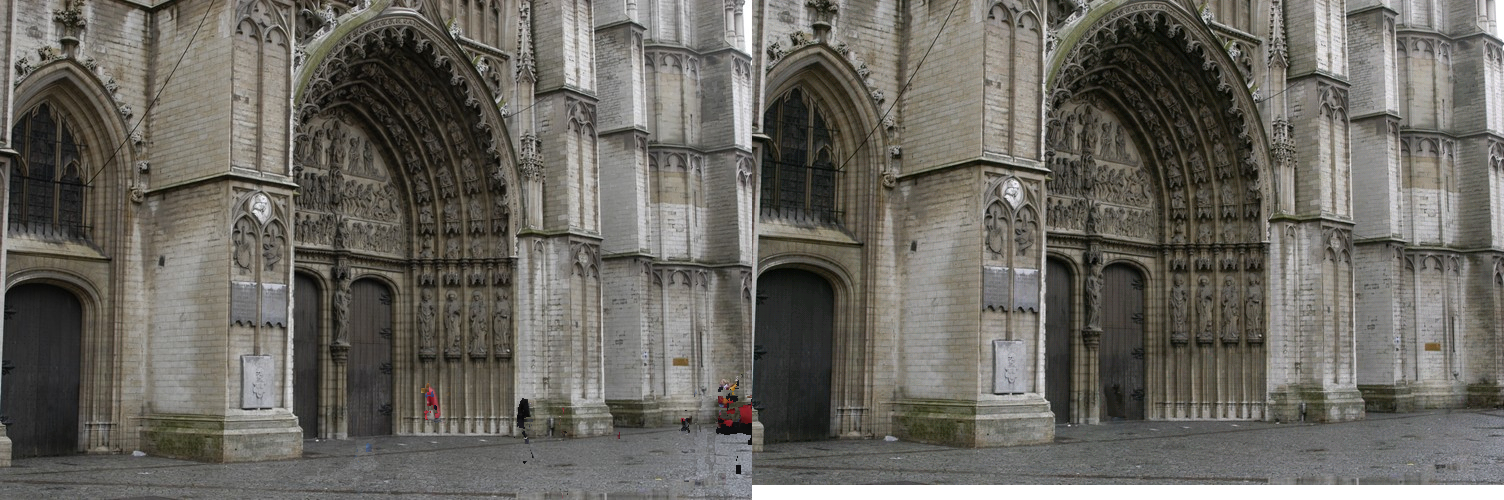

In [ ]:
combine = diff + img_diff
imshow(np.concatenate([choose_by_mask(images, combine), result], 1))